In [63]:
from nilearn import datasets, maskers, plotting,image,connectome
import matplotlib.pyplot as plt
import numpy as np
from bids.layout import BIDSLayout
import networkx as nx

In [64]:
#base directory
fmriprep_dir='../Full-Dataset'
layout=BIDSLayout(fmriprep_dir)

In [65]:
len(layout.get_subjects())

71

In [77]:
atlas_ho = datasets.fetch_atlas_aal('SPM12')

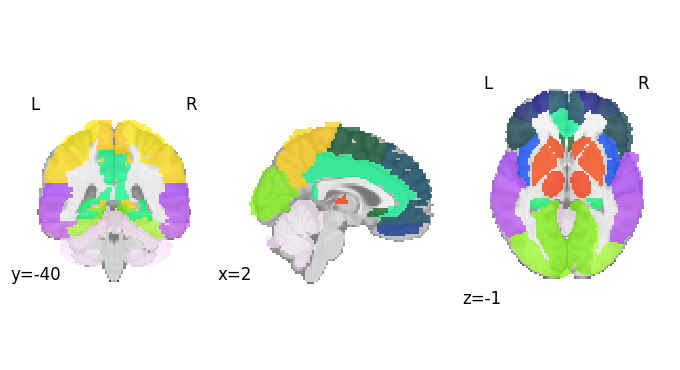

In [78]:
# Location of HarvardOxford parcellation atlas
atlas_file = atlas_ho.maps

# Visualize parcellation atlas
plotting.plot_roi(atlas_file, draw_cross=False, annotate=True);

In [45]:
print(len(atlas_ho.labels))

116


In [46]:
fmri_files=layout.get(datatype='func',extension='.nii.gz',return_type="file")

In [47]:
print(len(fmri_files))

71


In [48]:
fmri_data = image.load_img(fmri_files[0])

In [49]:
masker = maskers.NiftiLabelsMasker(labels_img=atlas_file, standardize=True, verbose=1,
                           memory="nilearn_cache", memory_level=2)

In [50]:
time_series = masker.fit_transform(fmri_data)

[NiftiLabelsMasker.wrapped] loading data from C:\Users\reub\nilearn_data\aal_SPM12\aal\atlas\AAL.nii
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x00000204D2FD2A10>, interpolation='nearest', target_shape=(96, 96, 32), target_affine=array([[ 2.498985e+00, -1.743714e-02,  1.174075e-01, -1.162616e+02],
       [ 2.037038e-02,  2.497648e+00, -1.810224e-01, -1.072518e+02],
       [-6.825235e-02,  1.069983e-01,  4.244718e+00, -4.414224e+01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]))
_____________________________________________________resample_img - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x00000204D2C67FD0>, <nilearn.maskers.

c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\joblib\memory.py:856: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  output = self.func(*args, **kwargs)


_______________________________________________filter_and_extract - 3.6s, 0.1min


In [51]:
# Print the shape of the extracted time series data
print("Shape of time series data:", time_series.shape)

Shape of time series data: (341, 116)


In [52]:
corr_matrix=connectome.ConnectivityMeasure(kind='correlation', standardize='zscore_sample').fit_transform([time_series])[0]

In [53]:
corr_matrix.shape

(116, 116)

In [54]:
# Mask the main diagonal for visualization:
np.fill_diagonal(corr_matrix, 0)

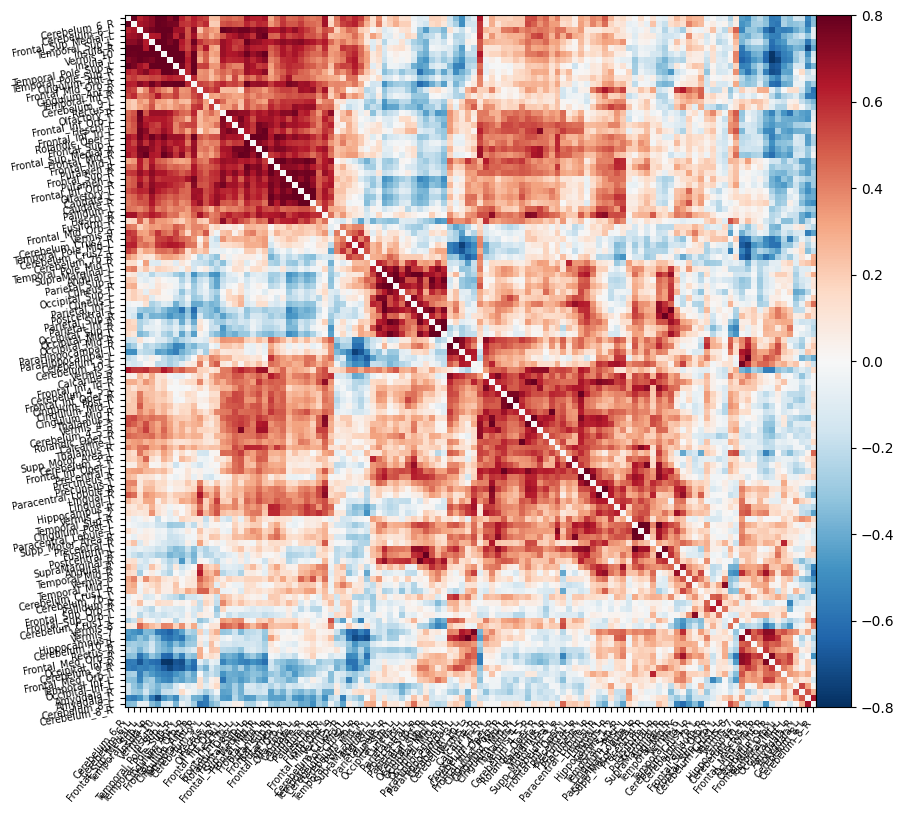

In [55]:
# Plot correlation matrix - note: matrix is ordered for block-like representation
plotting.plot_matrix(corr_matrix, figure=(10, 8), labels=atlas_ho.labels,
                     vmax=0.8, vmin=-0.8, reorder=True);

In [73]:
#base directory
def create_fc_matrices():
    fmriprep_dir='../Full-Dataset'
    layout=BIDSLayout(fmriprep_dir)
    atlas_ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
    # Location of HarvardOxford parcellation atlas
    atlas_file = atlas_ho.maps

    print(f'Number of labels in the atlas: {len(atlas_ho.labels)}\n')

    fmri_files=layout.get(datatype='func',extension='.nii.gz',return_type="file")

    print(f'Number of Subjects in the Dataset:{len(fmri_files)}\n')

    masker = maskers.NiftiLabelsMasker(labels_img=atlas_file, standardize='zscore_sample', verbose=0)
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation',standardize='zscore_sample')

    subject_corr=[]

    for file in fmri_files:
        print(file)
        fmri_data = image.load_img(file)
        time_series = masker.fit_transform(fmri_data)
        corr_matrix=correlation_measure.fit_transform([time_series])[0]
        corr_matrix = np.corrcoef(corr_matrix, rowvar=False)
        np.fill_diagonal(corr_matrix, 0)
        subject_corr.append(corr_matrix)
        print(f'Subjects left to Compute {len(fmri_files)-len(subject_corr)}')
    
    return subject_corr

In [74]:
def create_knn_graph(fc_matrices, k):
    # Calculate group FC matrix by averaging individual FC matrices
    group_fc_matrix = np.mean(fc_matrices, axis=0)

    # Calculate pairwise correlation coefficients
    mean_correlation_matrix = np.corrcoef(group_fc_matrix, rowvar=False)

    # Create k-NN graph
    G = nx.Graph()
    num_nodes = mean_correlation_matrix.shape[0]

    for i in range(num_nodes):
        # Find the indices of the top k edges in terms of connectivity strength
        top_k_indices = np.argsort(mean_correlation_matrix[i, :])[-k:]

        # Add edges to the graph
        for j in top_k_indices:
            if i != j:  # Avoid self-loops
                G.add_edge(i, j, weight=mean_correlation_matrix[i, j])

    return G, mean_correlation_matrix

In [75]:
k = 5
fc_matrices=create_fc_matrices()
knn_graph, mean_corr_matrix = create_knn_graph(fc_matrices, k)
# Extract adjacency matrix and labels
# adjacency_matrix = nx.adjacency_matrix(knn_graph).todense()
# labels = list(knn_graph.nodes)

Number of labels in the atlas: 49

Number of Subjects in the Dataset:71

c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-01\func\sub-01_task-speech_bold.nii.gz
Subjects left to Compute 70
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-02\func\sub-02_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 35, 37, 38, 39, 11, 14, 15, 16, 25}. Label image only contains 39 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 69
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-03\func\sub-03_task-speech_bold.nii.gz
Subjects left to Compute 68
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-04\func\sub-04_task-speech_bold.nii.gz
Subjects left to Compute 67
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-05\func\sub-05_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 34, 35, 37, 38, 39, 8, 9, 40, 11, 12, 44, 14, 15, 16, 25, 27}. Label image only contains 32 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 66
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-06\func\sub-06_task-speech_bold.nii.gz
Subjects left to Compute 65
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-07\func\sub-07_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {25}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 64
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-08\func\sub-08_task-speech_bold.nii.gz
Subjects left to Compute 63
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-09\func\sub-09_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 62
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-10\func\sub-10_task-speech_bold.nii.gz
Subjects left to Compute 61
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-11\func\sub-11_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 60
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-12\func\sub-12_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {2, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 23, 24, 25, 27, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48}. Label image only contains 16 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 59
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-13\func\sub-13_task-speech_bold.nii.gz
Subjects left to Compute 58
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-14\func\sub-14_task-speech_bold.nii.gz
Subjects left to Compute 57
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-15\func\sub-15_task-speech_bold.nii.gz
Subjects left to Compute 56
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-16\func\sub-16_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 35, 37, 38, 39, 11, 14, 15, 16, 25}. Label image only contains 39 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 55
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-17\func\sub-17_task-speech_bold.nii.gz
Subjects left to Compute 54
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-18\func\sub-18_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 53
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-19\func\sub-19_task-speech_bold.nii.gz
Subjects left to Compute 52
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-20\func\sub-20_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 51
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-21\func\sub-21_task-speech_bold.nii.gz
Subjects left to Compute 50
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-22\func\sub-22_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {25, 15}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 49
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-23\func\sub-23_task-speech_bold.nii.gz
Subjects left to Compute 48
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-24\func\sub-24_task-speech_bold.nii.gz
Subjects left to Compute 47
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-25\func\sub-25_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 35, 38, 39, 40, 11, 15, 16}. Label image only contains 39 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 46
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-26\func\sub-26_task-speech_bold.nii.gz
Subjects left to Compute 45
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-27\func\sub-27_task-speech_bold.nii.gz
Subjects left to Compute 44
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-28\func\sub-28_task-speech_bold.nii.gz
Subjects left to Compute 43
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-29\func\sub-29_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {25, 34, 37, 14}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 42
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-30\func\sub-30_task-speech_bold.nii.gz
Subjects left to Compute 41
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-32\func\sub-32_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 38}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 40
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-33\func\sub-33_task-speech_bold.nii.gz
Subjects left to Compute 39
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-34\func\sub-34_task-speech_bold.nii.gz
Subjects left to Compute 38
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-36\func\sub-36_task-speech_bold.nii.gz
Subjects left to Compute 37
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-37\func\sub-37_task-speech_bold.nii.gz
Subjects left to Compute 36
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-38\func\sub-38_task-speech_bold.nii.gz
Subjects left to Compute 35
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-40\func\sub-40_task-speech_bold.nii.gz
Subjects left to Compute 34
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-42\func\sub-42_task-speech_bold.nii.gz
Subjects left to Compute 33
c:\Reu

c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 32
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-44\func\sub-44_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 31
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-45\func\sub-45_task-speech_bold.nii.gz
Subjects left to Compute 30
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-46\func\sub-46_task-speech_bold.nii.gz
Subjects left to Compute 29
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-47\func\sub-47_task-speech_bold.nii.gz
Subjects left to Compute 28
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-48\func\sub-48_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14, 15}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 27
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-49\func\sub-49_task-speech_bold.nii.gz
Subjects left to Compute 26
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-50\func\sub-50_task-speech_bold.nii.gz
Subjects left to Compute 25
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-53\func\sub-53_task-speech_bold.nii.gz
Subjects left to Compute 24
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-54\func\sub-54_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 23
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-55\func\sub-55_task-speech_bold.nii.gz
Subjects left to Compute 22
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-56\func\sub-56_task-speech_bold.nii.gz
Subjects left to Compute 21
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-57\func\sub-57_task-speech_bold.nii.gz
Subjects left to Compute 20
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-58\func\sub-58_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {37}. Label image only contains 48 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 19
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-59\func\sub-59_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 38, 39, 40, 14, 15, 16}. Label image only contains 41 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 18
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-60\func\sub-60_task-speech_bold.nii.gz
Subjects left to Compute 17
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-61\func\sub-61_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 35, 38, 39, 15, 25, 27}. Label image only contains 40 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 16
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-62\func\sub-62_task-speech_bold.nii.gz
Subjects left to Compute 15
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-63\func\sub-63_task-speech_bold.nii.gz
Subjects left to Compute 14
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-64\func\sub-64_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 15}. Label image only contains 45 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 13
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-65\func\sub-65_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {38}. Label image only contains 44 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 12
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-66\func\sub-66_task-speech_bold.nii.gz
Subjects left to Compute 11
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-67\func\sub-67_task-speech_bold.nii.gz
Subjects left to Compute 10
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-68\func\sub-68_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {37, 14}. Label image only contains 47 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 9
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-69\func\sub-69_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 8
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-70\func\sub-70_task-speech_bold.nii.gz
Subjects left to Compute 7
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-71\func\sub-71_task-speech_bold.nii.gz
Subjects left to Compute 6
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-72\func\sub-72_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34, 37, 14}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 5
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-73\func\sub-73_task-speech_bold.nii.gz
Subjects left to Compute 4
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-74\func\sub-74_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {33, 34, 37, 38, 8, 11, 14, 15, 25, 27}. Label image only contains 39 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 3
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-75\func\sub-75_task-speech_bold.nii.gz
Subjects left to Compute 2
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-76\func\sub-76_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {34}. Label image only contains 46 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 1
c:\Reuben's Code's\PyTorch\Schizophrenia\Data-Prep\..\Full-Dataset\sub-77\func\sub-77_task-speech_bold.nii.gz


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {35, 38, 39, 8, 40, 11, 15, 16, 25, 27}. Label image only contains 36 labels (including background).
  warnings.warn("After resampling the label image to the "


Subjects left to Compute 0


c:\Reuben's Code's\PyTorch\Schizophrenia\venv\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (48,48) (38,38) 